In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math
import re
%matplotlib inline
pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_csv('final_df.csv')

# A = Betting 
# B = Weather
# C = Location
# D = Teams

In [3]:
### Drop Null Values *will amend if there is time* ###
df = df.dropna(subset=['weather_temperature'])

### Drop Columns not need for EDA ###
df = df.drop(columns=['weather_humidity','weather_detail','stadium_address','stadium_weather_station_code',
                      'stadium_weather_type','STATION','ELEVATION'])
df['over_under_result'] = np.where(df['over_under_result'] == 'Over',1,0)

## Target Variable: Over/Under Result

In [4]:
### Check Class Imbalalance ###

df.over_under_result.value_counts()

0    4853
1    4553
Name: over_under_result, dtype: int64

In [5]:
### Percentages of Classes ###
print("Percent 'Under' Outcomes")
print(round((df.groupby(['over_under_result']).over_under_result.count()[0]/
       df.groupby(['over_under_result']).over_under_result.count().sum()),2))
print("Percent 'Over' Outcomes")
print(round((df.groupby(['over_under_result']).over_under_result.count()[1]/
       df.groupby(['over_under_result']).over_under_result.count().sum()),2))


Percent 'Under' Outcomes
0.52
Percent 'Over' Outcomes
0.48


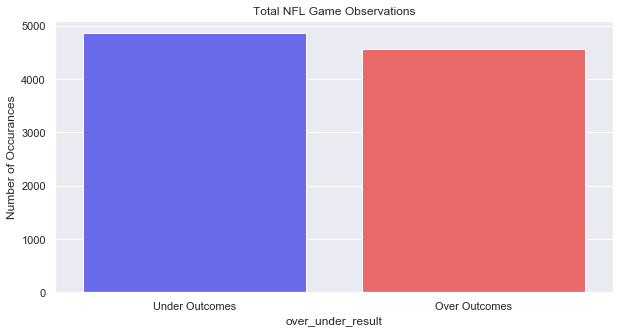

In [331]:
### Target Variable Countplot to help Visualize Class Imbalance ###

plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
sns.countplot(df['over_under_result'], palette="seismic")
plt.title('Total NFL Game Observations')
plt.ylabel('Number of Occurances')
plt.xticks(np.arange(2), ['Under Outcomes','Over Outcomes'])
plt.show()

## Independent Variable 1: Season

1979 to 2020

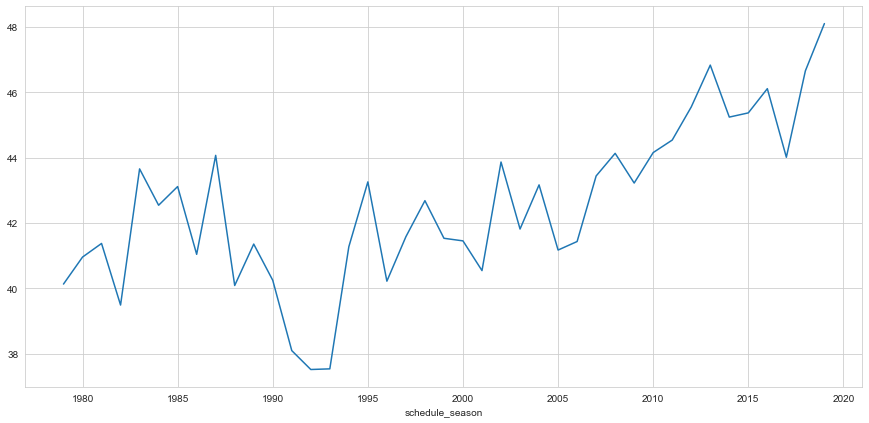

In [7]:
# Total Points seems to be slightly increasing over time

fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['schedule_season'])['total'].mean().plot(ax=ax)

## Independent Variable 2: Schedule Week

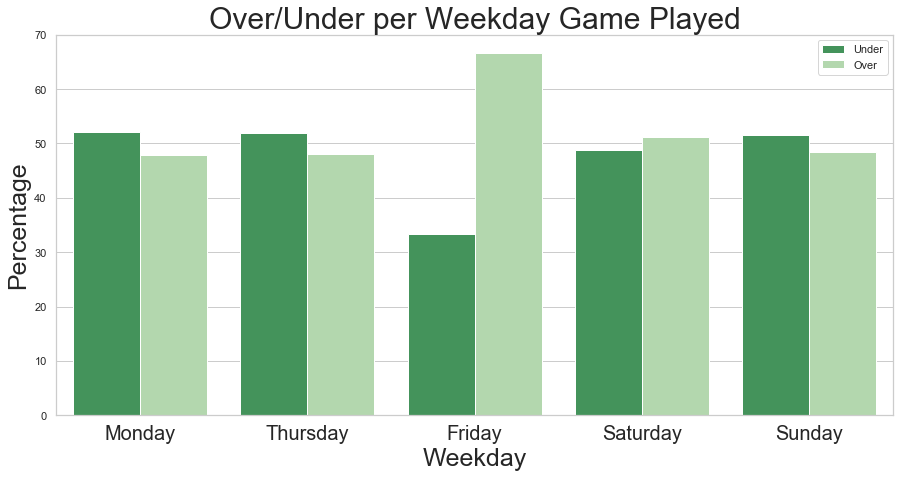

In [408]:
### Build Dataset that Groups by Week and Over Result, then get Percentage Over or Under ###
weekday_percent = (df.groupby(['weekday'])['over_under_result'].value_counts(normalize=True)
                     .rename('percentage').mul(100).reset_index().sort_values('over_under_result'))

### Get Rid of Monday and Tuesday because not enough games are played on those day ###
weekday_percent = weekday_percent[(weekday_percent.weekday != 1) & (weekday_percent.weekday != 2)]

### Plot ###
plt.figure(figsize = (15,7))
sns.set_style("whitegrid")
weekday_bar = sns.barplot(x="weekday", y="percentage", hue="over_under_result", data=weekday_percent, palette='Greens_r')
weekday_bar = plt.xticks(np.arange(5), ['Monday','Thursday','Friday','Saturday','Sunday'],fontsize=20)
weekday_bar = plt.xlabel('Weekday',fontsize=25)
weekday_bar = plt.ylabel('Percentage',fontsize=25)
weekday_bar = plt.title('Over/Under per Weekday Game Played',fontsize = 30)
weekday_bar = plt.legend()
weekday_bar.get_texts()[1].set_text('Over')
weekday_bar.get_texts()[0].set_text('Under')
plt.savefig('weekday_bar.png')


In [ ]:
### Friday Has a Sample Size of 9 ###

## Independent Variable 3A: Spread

In [40]:
spread_percent = (df.groupby(['spread_favorite'])['over_under_result'].value_counts(normalize=True)
                     .rename('percentage').mul(100).reset_index().sort_values('over_under_result'))

### Spread 17.5 and above sample too small ###
spread_percent = spread_percent[(spread_percent.spread_favorite < 15)]

In [43]:
#spread = df.groupby(['spread_favorite']).over_under_line.count()
#spread

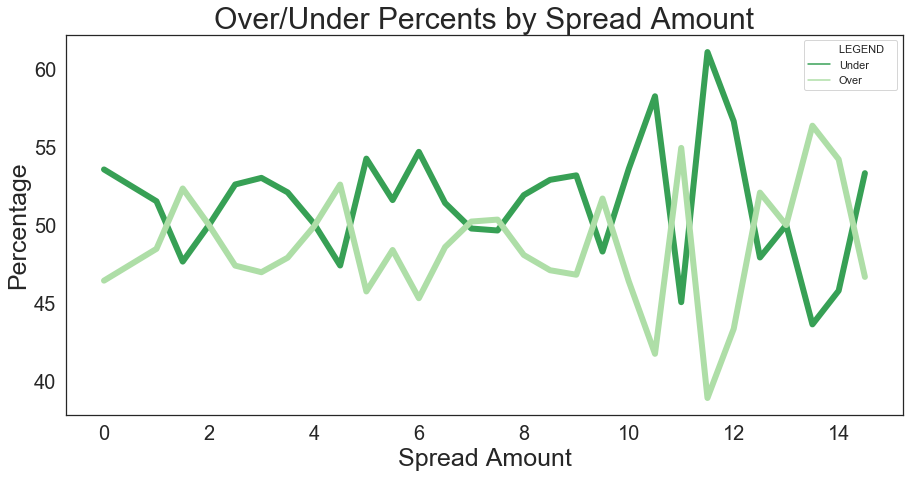

In [497]:
plt.figure(figsize = (15,7))
sns.set_style("white")
spread_line = sns.lineplot(x="spread_favorite", y="percentage", hue="over_under_result", 
                           data=spread_percent, palette='Greens_r',linewidth = 6)
spread_line = plt.title('Over/Under Percents by Spread Amount',fontsize = 30)
spread_line = plt.xticks(fontsize=20)
spread_line = plt.yticks(fontsize=20)
spread_line = plt.xlabel('Spread Amount',fontsize=25)
spread_line = plt.ylabel('Percentage',fontsize=25)
spread_line = plt.legend()
spread_legend = plt.legend()
spread_legend.get_texts()[2].set_text('Over')
spread_legend.get_texts()[1].set_text('Under')
spread_legend.get_texts()[0].set_text('LEGEND   ')
plt.savefig('spread_plot.png')
### No Real Relationship, But as the number gets bigger the percentages start to increase ###


## Independant Variable 4B: Wind Mile per Hour

In [61]:
df.weather_wind_mph.describe()

count    9406.000000
mean        7.310121
std         5.715796
min         0.000000
25%         1.000000
50%         8.000000
75%        11.000000
max        40.000000
Name: weather_wind_mph, dtype: float64

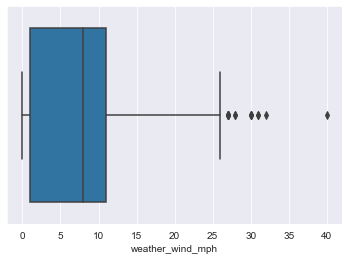

In [62]:
sns.boxplot(df.weather_wind_mph)

In [66]:
wind_percent = (df.groupby(['weather_wind_mph'])['over_under_result'].value_counts(normalize=True)
                     .rename('percentage').mul(100).reset_index().sort_values('over_under_result'))

### Spread 17.5 and above sample too small ###
wind_percent['weather_wind_mph'] = np.where(wind_percent['weather_wind_mph'] >= 21,21,wind_percent['weather_wind_mph'])



In [67]:
#wind = df.groupby(['weather_wind_mph']).over_under_line.count()
#wind


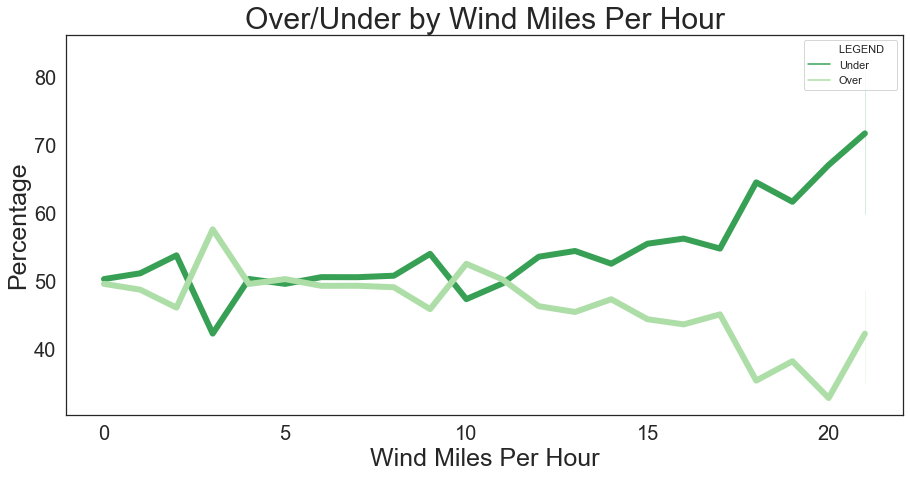

In [427]:
plt.figure(figsize = (15,7))
sns.set_style("white")
wind_plot = sns.lineplot(x="weather_wind_mph", y="percentage", hue="over_under_result", 
                         data=wind_percent, palette='Greens_r',linewidth = 6)
wind_plot = plt.title('Over/Under by Wind Miles Per Hour',fontsize = 30)
wind_plot = plt.xticks(fontsize=20)
wind_plot = plt.yticks(fontsize=20)
wind_plot = plt.xlabel('Wind Miles Per Hour',fontsize=25)
wind_plot = plt.ylabel('Percentage',fontsize=25)
wind_plot = plt.legend()
wind_legend = plt.legend()
wind_legend.get_texts()[2].set_text('Over')
wind_legend.get_texts()[1].set_text('Under')
wind_legend.get_texts()[0].set_text('LEGEND   ')
plt.savefig('wind_plot.png')



In [80]:
wind_groups=[]
for i in df['weather_wind_mph']:
    if (i < 14):
        wind_groups.append(0)
    elif (i >= 14) & (i <= 21):
        wind_groups.append(1)
    else:
        wind_groups.append(2)
df['wind_group'] = wind_groups

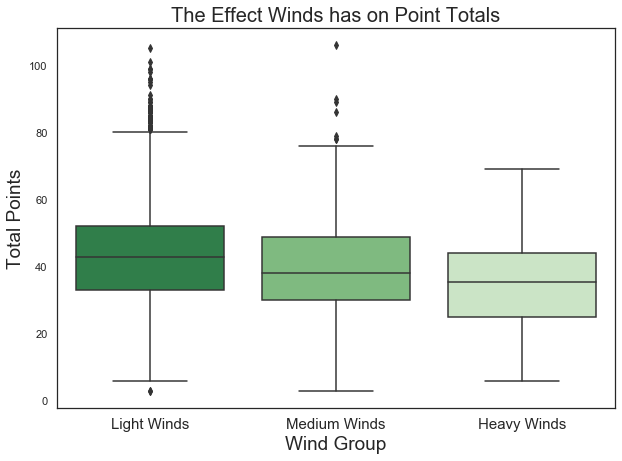

In [428]:
plt.figure(figsize = (10,7));

wind_box = sns.boxplot(x = 'wind_group', y = 'total',data = df, palette="Greens_r")
wind_box.set_title('The Effect Winds has on Point Totals',fontsize=20)
wind_box.set_ylabel('Total Points',fontsize=19)
wind_box.set_xlabel('Wind Group',fontsize=19)
wind_box.set_xticklabels(['Light Winds','Medium Winds','Heavy Winds'],fontsize=15)
plt.savefig('wind_box.png')
plt.show()

# Independant Variable: Tempurature

In [437]:
round_temps = []
for temp in df.weather_temperature:
    round_temps.append(round(temp))

df['round_temps'] = round_temps

In [438]:
temp_percent = (df.groupby(['round_temps'])['over_under_result'].value_counts(normalize=True)
                     .rename('percentage').mul(100).reset_index().sort_values('over_under_result'))

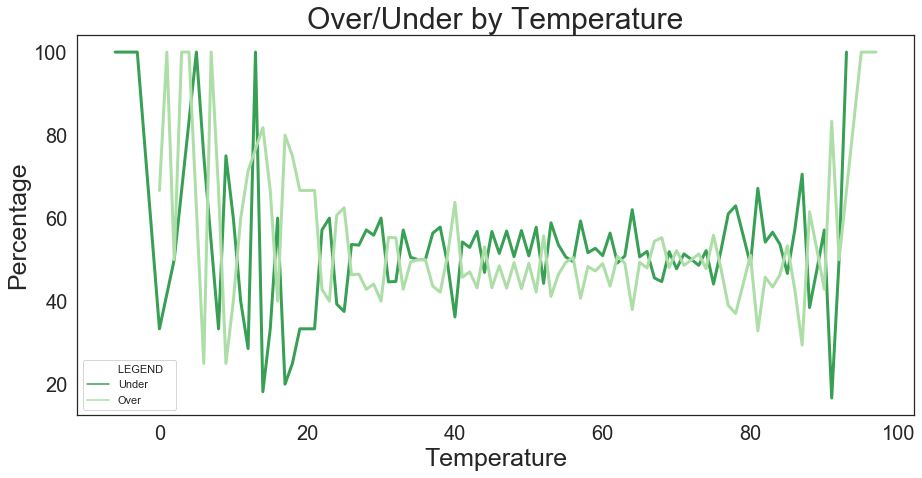

In [443]:
plt.figure(figsize = (15,7))
sns.set_style("white")
temp_plot = sns.lineplot(x="round_temps", y="percentage", hue="over_under_result", 
                         data=temp_percent, palette='Greens_r',linewidth = 3)
temp_plot = plt.title('Over/Under by Temperature',fontsize = 30)
temp_plot = plt.xticks(fontsize=20)
temp_plot = plt.yticks(fontsize=20)
temp_plot = plt.xlabel('Temperature',fontsize=25)
temp_plot = plt.ylabel('Percentage',fontsize=25)
temp_plot = plt.legend()
temp_legend = plt.legend()
temp_legend.get_texts()[2].set_text('Over')
temp_legend.get_texts()[1].set_text('Under')
temp_legend.get_texts()[0].set_text('LEGEND   ')
plt.savefig('temp_plot.png')

Text(0.5, 0, 'Temperature')

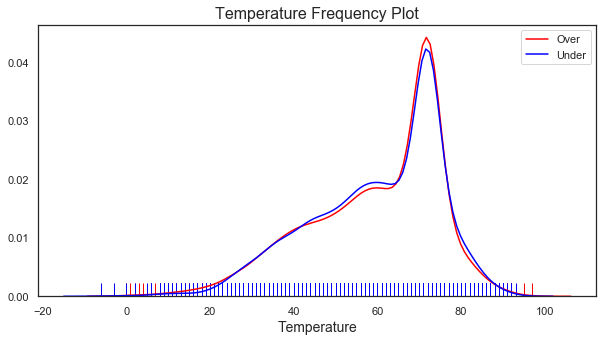

In [492]:
fig, ax = plt.subplots(figsize = (10,5));
pup = sns.distplot(df[df['over_under_result']== 1].weather_temperature, color='red',hist=False, rug=True, label = 'Over')
pup = sns.distplot(df[df['over_under_result']== 0].weather_temperature, color='blue',hist=False, rug=True, label = 'Under')
pup.set_title('Temperature Frequency Plot',fontsize=16)
pup.set_xlabel('Temperature',fontsize=14)


## Independant Variable 5C: Stadium Capacity

In [116]:
df.stadium_capacity.describe()

count      9406.000000
mean      69070.465767
std        8743.523179
min       27000.000000
25%       64767.000000
50%       68756.000000
75%       76125.000000
max      100000.000000
Name: stadium_capacity, dtype: float64

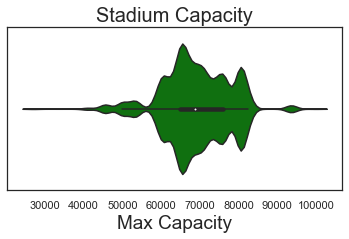

In [388]:
fig, ax = plt.subplots(figsize=(6,3))
sns.set_style("white")
#plt.figure(figsize = (6,6));
capacity_violin = sns.violinplot(x=df["stadium_capacity"],color = 'green')
capacity_violin.set_title('Stadium Capacity',fontsize=20)
capacity_violin.set_xlabel('Max Capacity',fontsize=19)
plt.savefig('capacity_violin.png')


Text(0.5, 0, 'Capacity')

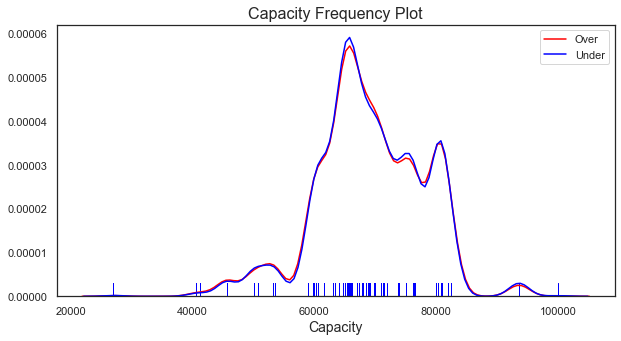

In [393]:
fig, ax = plt.subplots(figsize = (10,5));
pup = sns.distplot(df[df['over_under_result']== 1].stadium_capacity, color='red',hist=False, rug=True, label = 'Over')
pup = sns.distplot(df[df['over_under_result']== 0].stadium_capacity, color='blue',hist=False, rug=True, label = 'Under')
pup.set_title('Capacity Frequency Plot',fontsize=16)
pup.set_xlabel('Capacity',fontsize=14)



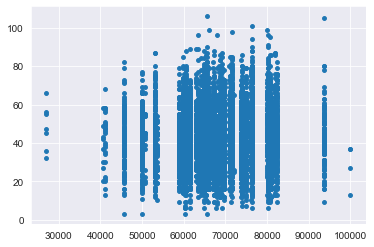

In [175]:
plt.scatter('stadium_capacity', 'total', data=df,s=15)

In [204]:
stadium_groups=[]
for i in df['stadium_capacity']:
    if (i < 50000):
        stadium_groups.append(0)
    elif (i >= 50000) & (i <= 85000):
        stadium_groups.append(1)
    else:
        stadium_groups.append(2)
df['stadium_group'] = stadium_groups

In [205]:
df.groupby(['stadium_group']).over_under_result.mean()

stadium_group
0    0.514451
1    0.483935
2    0.447368
Name: over_under_result, dtype: float64

In [ ]:
### Build Dataset that Groups by Week and Over Result, then get Percentage Over or Under ###
stadium_percent = (df.groupby(['stadium_group'])['over_under_result'].value_counts(normalize=True)
                     .rename('percentage').mul(100).reset_index().sort_values('over_under_result'))

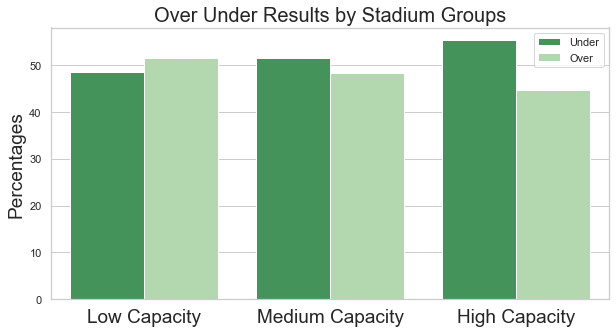

In [384]:

### Plot ###
plt.figure(figsize = (10,5))
sns.set_style("whitegrid")
stadium_bar = sns.barplot(x="stadium_group", y="percentage", hue="over_under_result", data=stadium_percent, palette='Greens_r')
stadium_bar = plt.xticks(np.arange(3), ['Low Capacity','Medium Capacity','High Capacity'],fontsize=19)
stadium_bar = plt.xlabel('',fontsize=19)
stadium_bar = plt.ylabel('Percentages',fontsize=19)
stadium_bar = plt.title('Over Under Results by Stadium Groups',fontsize = 20)
stadium_bar = plt.legend()
stadium_bar.get_texts()[1].set_text('Over')
stadium_bar.get_texts()[0].set_text('Under')
plt.savefig('stadium_bar.png')


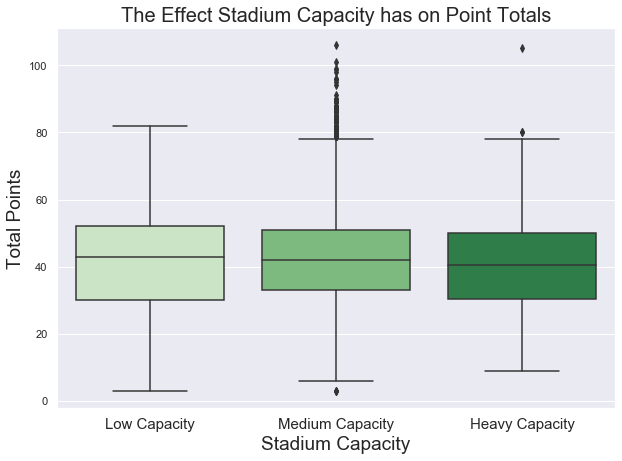

In [376]:
plt.figure(figsize = (10,7));
stadium_box = sns.boxplot(x = 'stadium_group', y = 'total', data = df, palette="Greens")
stadium_box.set_title('The Effect Stadium Capacity has on Point Totals',fontsize=20)
stadium_box.set_ylabel('Total Points',fontsize=19)
stadium_box.set_xlabel('Stadium Capacity',fontsize=19)
stadium_box.set_xticklabels(['Low Capacity','Medium Capacity','Heavy Capacity'],fontsize=15)
plt.show()

# Stadium Capacity and Wind

In [342]:
stadium_wind = df[(df.stadium_capacity > 60000) & (df.weather_wind_mph > 14)]
print(stadium_wind.shape)
stadium_wind = stadium_wind['over_under_result'].value_counts(normalize=True).mul(100)
stadium_wind


(868, 60)


0    59.21659
1    40.78341
Name: over_under_result, dtype: float64

In [343]:
df['stadium_wind'] = np.where((df['stadium_capacity'] > 60000) & (df['weather_wind_mph'] > 14), 1, 0)


# Independent Variable 6C: Distance Traveled

In [390]:
df.dist_diff.describe()

count    9406.000000
mean     1568.895098
std      1044.470120
min         0.000000
25%       718.421276
50%      1386.631741
75%      2149.236453
max      4390.866941
Name: dist_diff, dtype: float64

Text(0.5, 0, 'Distance Traveled')

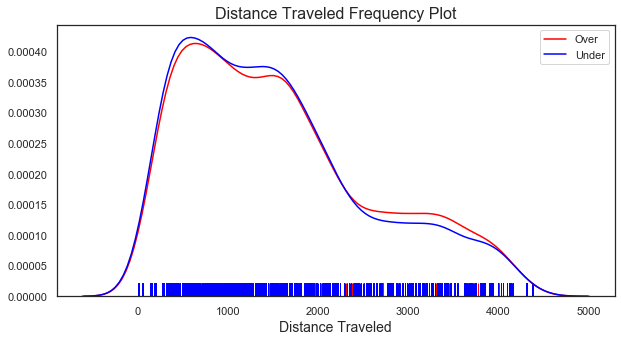

In [485]:
fig, ax = plt.subplots(figsize = (10,5));
pup = sns.distplot(df[df['over_under_result']== 1].dist_diff, color='red',hist=False, rug=True, label = 'Over')
pup = sns.distplot(df[df['over_under_result']== 0].dist_diff, color='blue',hist=False, rug=True, label = 'Under')
pup.set_title('Distance Traveled Frequency Plot',fontsize=16)
pup.set_xlabel('Distance Traveled',fontsize=14)


# Independent Variable 7D: Team Previous Season Data

In [25]:
df.columns

Index(['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home', 'score_away', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line',
       'stadium_neutral', 'weather_temperature', 'weather_wind_mph', 'total',
       'over_under_result', 'stadium_name', 'stadium_location', 'stadium_open',
       'stadium_type', 'stadium_capacity', 'stadium_surface', 'LATITUDE',
       'LONGITUDE', 'zipcode', 'zipcode_away', 'dist_diff', 'weekday',
       'home_W-L%', 'home_PD', 'home_MoV', 'home_SoS', 'home_SRS', 'home_OSRS',
       'home_DSRS', 'home_PF_per_game', 'home_PA_per_game', 'away_W-L%',
       'away_PD', 'away_MoV', 'away_SoS', 'away_SRS', 'away_OSRS', 'away_DSRS',
       'away_PF_per_game', 'away_PA_per_game', 'home_superbowl_odds',
       'away_superbowl_odds', 'diff_W-L%', 'diff_PD', 'diff_MoV', 'diff_SoS',
       'diff_SRS', 'diff_OSRS', 'diff_PF_per_game', 'diff_PA_per_game',
       'diff_superbowl_odds', 'Wind-Gr

In [51]:
season_data = df.drop(columns=['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'score_home', 'score_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line',
       'stadium_neutral', 'weather_temperature', 'weather_wind_mph', 'total',
       'over_under_result', 'stadium_name', 'stadium_location', 'stadium_open',
       'stadium_type', 'stadium_capacity', 'stadium_surface', 'LATITUDE',
       'LONGITUDE', 'zipcode', 'zipcode_away', 'dist_diff', 'weekday','Wind-Group',
        'home_OSRS','home_MoV','home_PD','away_OSRS','away_MoV','away_PD',
        'away_DSRS','away_SRS','home_DSRS','home_SRS','diff_MoV','diff_SRS','diff_OSRS'] )

In [52]:
season_data

,team_home,team_away,home_W-L%,home_SoS,home_PF_per_game,home_PA_per_game,away_W-L%,away_SoS,away_PF_per_game,away_PA_per_game,home_superbowl_odds,away_superbowl_odds,diff_W-L%,diff_PD,diff_SoS,diff_PF_per_game,diff_PA_per_game,diff_superbowl_odds
0,Tampa Bay Buccaneers,Detroit Lions,0.313,-2.2,15.0625,16.1875,0.438,-1.2,18.1250,18.7500,25000.0,3500.0,0.125,8.0,1.0,3.0625,2.5625,21500.0
1,Buffalo Bills,Miami Dolphins,0.313,0.0,18.8750,22.1250,0.688,0.2,23.2500,15.8750,30000.0,900.0,0.375,170.0,0.2,4.3750,6.2500,29100.0
2,Chicago Bears,Green Bay Packers,0.438,-1.1,15.8125,17.1250,0.531,0.7,15.5625,16.8125,4000.0,10000.0,0.093,1.0,1.8,0.2500,0.3125,6000.0
3,Denver Broncos,Cincinnati Bengals,0.625,-0.2,17.6250,12.3750,0.250,0.7,15.7500,17.7500,1200.0,2500.0,0.375,116.0,0.9,1.8750,5.3750,1300.0
4,Kansas City Chiefs,Baltimore Colts,0.250,0.9,15.1875,20.4375,0.313,2.6,14.9375,26.3125,75000.0,3500.0,0.063,98.0,1.7,0.2500,5.8750,71500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9824,Detroit Lions,Green Bay Packers,0.375,-0.8,20.2500,22.5000,0.406,-1.2,23.5000,25.0000,8000.0,2000.0,0.031,12.0,0.4,3.2500,2.5000,6000.0
9825,Houston Texans,Tennessee Titans,0.688,-1.5,25.1250,19.7500,0.563,-0.2,19.3750,18.9375,5000.0,8000.0,0.125,79.0,1.3,5.7500,0.8125,3000.0
9829,Minnesota Vikings,Chicago Bears,0.531,-0.6,22.5000,21.3125,0.750,-2.3,26.3125,17.6875,2000.0,1200.0,0.219,119.0,1.7,3.8125,3.6250,800.0
9834,Houston Texans,Buffalo Bills,0.688,-1.5,25.1250,19.7500,0.375,-0.3,16.8125,23.3750,5000.0,10000.0,0.313,191.0,1.2,8.3125,3.6250,5000.0


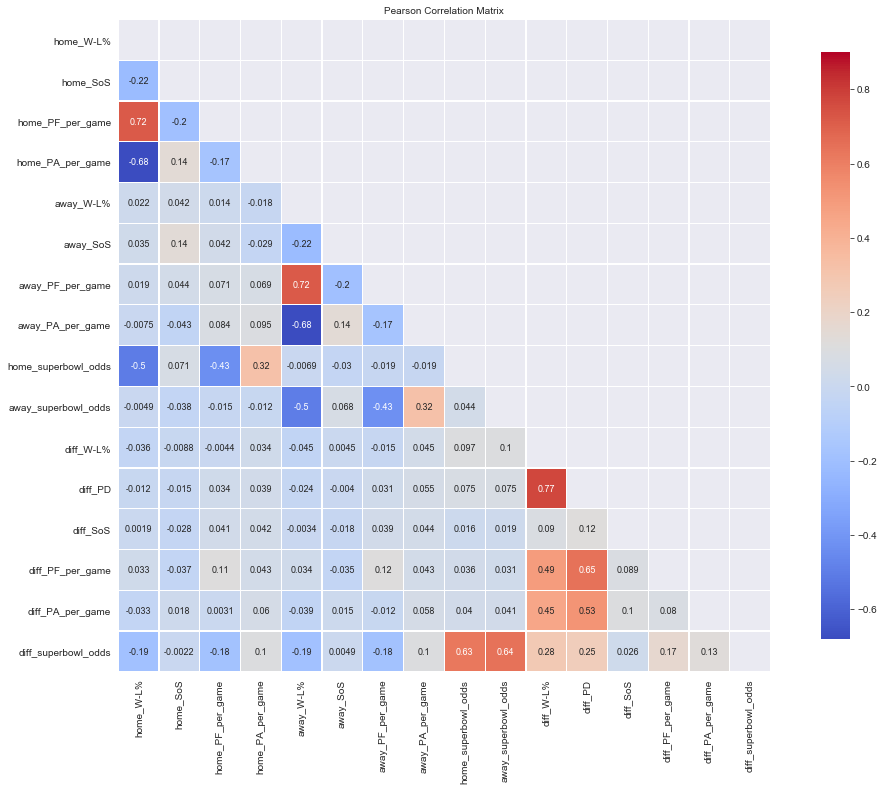

In [53]:
# Plot Correlation to Visualize Multi-Collinearity

mask = np.zeros_like(season_data.corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(18, 12))
plt.title('Pearson Correlation Matrix',fontsize=10)

sns.heatmap(season_data.corr(),linewidths=0.25,vmax=0.9,square=True,cmap="coolwarm",
            linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});
plt.show()

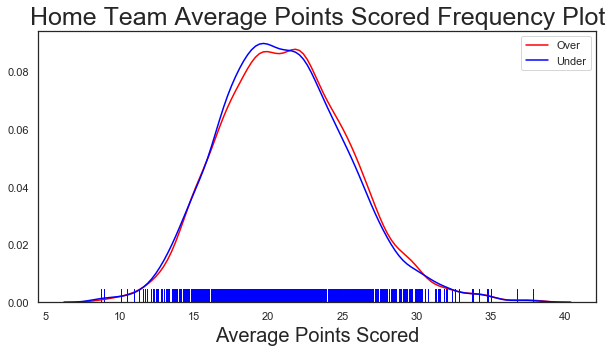

In [488]:
fig, ax = plt.subplots(figsize = (10,5));
sns.set_style('white')
home_freq = sns.distplot(df[df['over_under_result']== 1].home_PF_per_game, color='red',hist=False, rug=True, label = 'Over')
home_freq = sns.distplot(df[df['over_under_result']== 0].home_PF_per_game, color='blue',hist=False, rug=True, label = 'Under')
home_freq.set_title('Home Team Average Points Scored Frequency Plot',fontsize=25)
home_freq.set_xlabel('Average Points Scored',fontsize=20)
plt.savefig('home_freq.png')


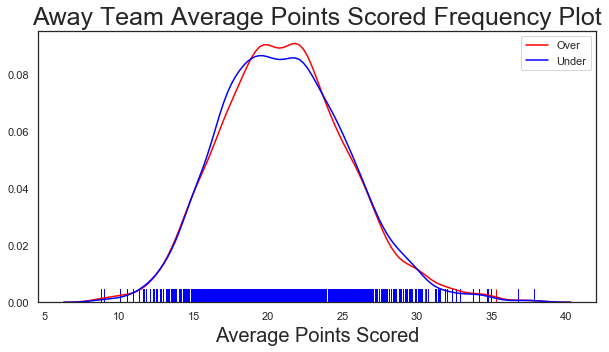

In [491]:
fig, ax = plt.subplots(figsize = (10,5));
sns.set_style('white')
away_freq = sns.distplot(df[df['over_under_result']== 1].away_PF_per_game, color='red',hist=False, rug=True, label = 'Over')
away_freq = sns.distplot(df[df['over_under_result']== 0].away_PF_per_game, color='blue',hist=False, rug=True, label = 'Under')
away_freq.set_title('Away Team Average Points Scored Frequency Plot',fontsize=25)
away_freq.set_xlabel('Average Points Scored',fontsize=20)
plt.savefig('away_freq.png')


# Superbowl Odds 

In [498]:
df.diff_superbowl_odds.describe()

count     9406.000000
mean      5425.830853
std       9251.259060
min          0.000000
25%       1000.000000
50%       2900.000000
75%       6200.000000
max      99760.000000
Name: diff_superbowl_odds, dtype: float64

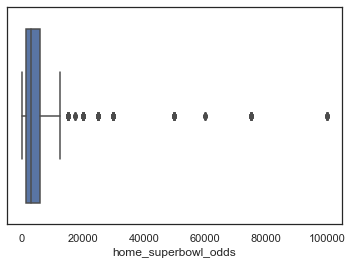

In [504]:
sns.boxplot(df.home_superbowl_odds)

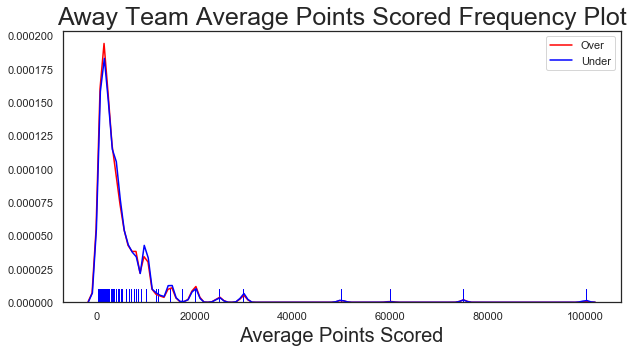

In [503]:
fig, ax = plt.subplots(figsize = (10,5));
sns.set_style('white')
away_freq = sns.distplot(df[df['over_under_result']== 1].home_superbowl_odds, color='red',hist=False, rug=True, label = 'Over')
away_freq = sns.distplot(df[df['over_under_result']== 0].home_superbowl_odds, color='blue',hist=False, rug=True, label = 'Under')
away_freq.set_title('Away Team Average Points Scored Frequency Plot',fontsize=25)
away_freq.set_xlabel('Average Points Scored',fontsize=20)
plt.savefig('away_freq.png')